In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
import matplotlib.pyplot as plt

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables
from pyccapt.calibration.mc import mc_tools

# The initial value for flight path length, which is the distance of local electrod to detector 
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

flightPathLength = 243 # 105.35 # mm 
# The initial value for t_0
t0 = 33 #68.48 # ns

analysis = False
save = True

$$\textbf{You can specify which dataset to use in below block}$$

In [2]:
variables.init()

tdc_model = 'roentdec' # TDC model: surface_concept or roentdec

# dataset name
# dataset_name = 'AL_data_b'
# dataset_name = 'OLO_AL_6_data'
# dataset_name = 'OLO_W_6_data'
# dataset_name = 'OLO_Ni_8_data'
# dataset_name = 'X6Cr17_2V30Min_5_data'
# dataset_name = "data_1029_Jun-27-2022_15-53_Pd"
dataset_name = 'data_115_Jul-27-2022_17-44_Powersweep3'

p = path.abspath(path.join("", "../../../../.."))

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/physics_experiment/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_laserIntensity = data['dld/laser_intensity'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [3]:
data

,dld/high_voltage,dld/laser_intensity,dld/start_counter,dld/t,dld/x,dld/y
0,7811.223145,46.0,5907.0,5907.0,-26.735539,-23.760130
1,7811.223145,46.0,2068.0,2068.0,-4.236108,16.569991
2,7811.223145,46.0,4862.0,4862.0,35.185401,1.817202
3,7811.223145,46.0,231.0,231.0,5.465585,15.735179
4,7811.223145,46.0,4390.0,4390.0,-12.998927,14.103826
...,...,...,...,...,...,...
551656,6900.186523,72.0,2131.0,2131.0,-24.667782,-19.999854
551657,6900.186523,72.0,4914.0,4914.0,25.293698,18.925075
551658,6900.186523,72.0,3294.0,3294.0,-33.654143,-12.994142
551659,6900.186523,72.0,2081.0,2081.0,-6.113855,-17.944540


In [4]:
# t0
dld_t = dld_t - t0

In [5]:
# Remove negative and zero TOF
threshold = 70
dld_highVoltage = dld_highVoltage[dld_t>threshold]
dld_laserIntensity = dld_laserIntensity[dld_t>threshold]
dld_x = dld_x[dld_t>threshold]
dld_y = dld_y[dld_t>threshold]
dld_t = dld_t[dld_t>threshold]

<IPython.core.display.Javascript object>


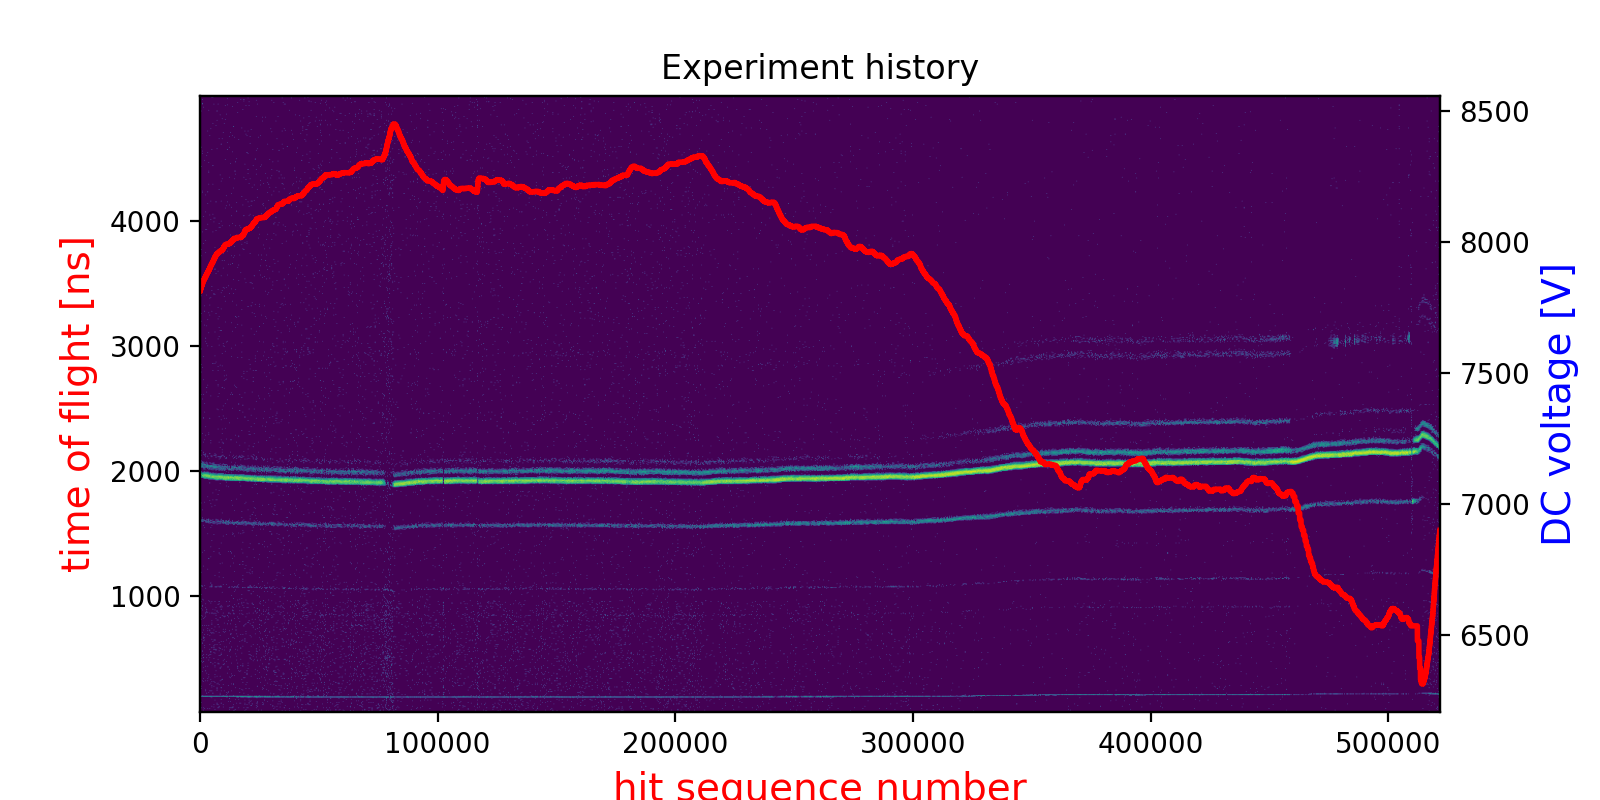

In [41]:
fig1, ax1 = plt.subplots(figsize=(8, 4))

yaxis = dld_t[dld_t < 5000]  # dld_t
# y[y>5000] = 0
xaxis = np.arange(len(yaxis))
heatmap, xedges, yedges = np.histogram2d(xaxis, yaxis, bins=(1200, 800))
heatmap[heatmap == 0] = 1  # to have zero after apply log
heatmap = np.log(heatmap)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# set x-axis label
ax1.set_xlabel("hit sequence number", color="red", fontsize=14)
# set y-axis label
ax1.set_ylabel("time of flight [ns]", color="red", fontsize=14)
plt.title("Experiment history")
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect="auto")

# plot high voltage curve
ax2 = ax1.twinx()

# dldGroupStorage[0] --> dld/high_voltage
high_voltage = dld_highVoltage[dld_t < 5000]
xaxis = np.arange(len(high_voltage))
ax2.plot(xaxis, high_voltage, color='r', linewidth=2)
ax2.set_ylabel("DC voltage [V]", color="blue", fontsize=14)
plt.show()

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

<IPython.core.display.Javascript object>


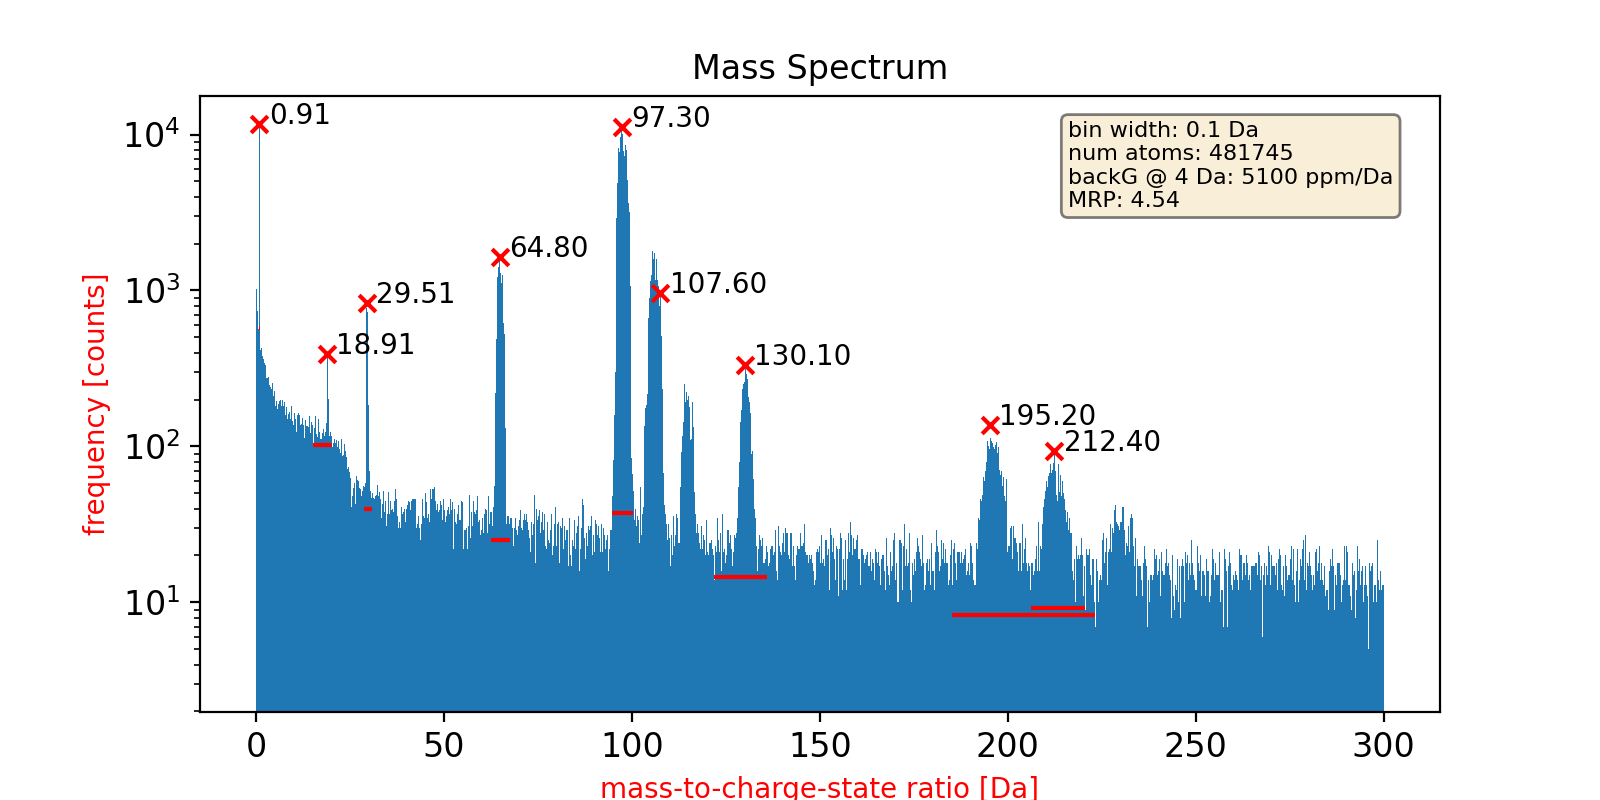

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [4.53591825]
Peaks  0 is: 0.91 peak window sides are: 0.81 - 1.01
Peaks  1 is: 18.91 peak window sides are: 18.71 - 19.31
Peaks  2 is: 29.51 peak window sides are: 29.31 - 29.81
Peaks  3 is: 64.80 peak window sides are: 64.00 - 65.80
Peaks  4 is: 97.30 peak window sides are: 96.10 - 98.80
Peaks  5 is: 107.60 peak window sides are: 104.20 - 107.90
Peaks  6 is: 130.10 peak window sides are: 129.20 - 131.50
Peaks  7 is: 195.20 peak window sides are: 193.80 - 197.90
Peaks  8 is: 212.40 peak window sides are: 210.10 - 213.20


In [44]:
mc_seb_ini = mc_tools.tof2mc(dld_t, 0, dld_highVoltage, dld_highVoltage, dld_x, dld_y, flightPathLength, mode='laser_pulse')
max_hist_ini, left_right_peaks_ini, peaks_sides_ini, max_paek_edges_ini, index_max_ini = tools.massSpecPlot(mc_seb_ini[mc_seb_ini < 300], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name=figname)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))

<IPython.core.display.Javascript object>


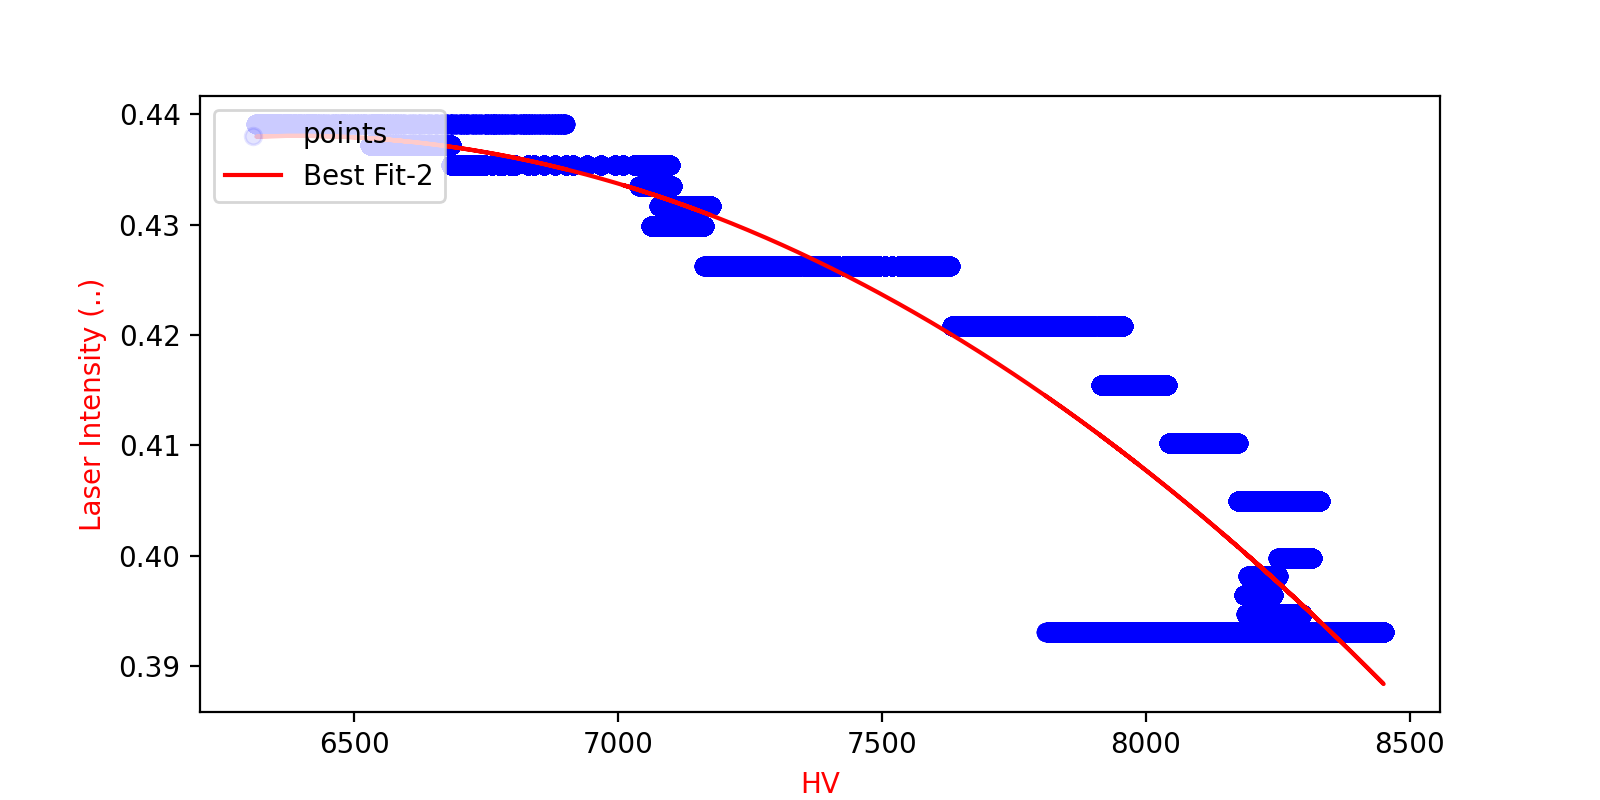

In [46]:
OD = (dld_laserIntensity - 265) / (270*2)
dld_laserIntensity_p = 10.0**OD
high_voltage = (8000 - dld_highVoltage) / 8000

fig1, ax1 = plt.subplots(figsize=(8, 4))
x = plt.scatter(dld_highVoltage, dld_laserIntensity_p, color="blue", label='points', alpha=0.1)
ax1.set_ylabel("Laser Intensity (..)", color="red", fontsize=10)
ax1.set_xlabel("HV", color="red", fontsize=10)

p = np.polyfit(dld_highVoltage, dld_laserIntensity_p, 2)
# p1 = np.polyfit(high_voltage[dld_laserIntensity_p < 0.42], dld_laserIntensity_p[dld_laserIntensity_p < 0.42], 1)
y = plt.plot(dld_highVoltage ,np.polyval(p, dld_highVoltage), color='red',label='Best Fit-2')
#z = plt.plot(high_voltage[dld_laserIntensity_p < 0.42] ,np.polyval(p1, high_voltage[dld_laserIntensity_p < 0.42]), color='green',label='Best Fit-1')

plt.legend(handles=[x, y[0]], loc='upper left')
if save==True:
    plt.savefig(variables.result_path + "//graph_%s.svg" % figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + "//graph_%s.png" % figname, format="png", dpi=600)
plt.show()